# Part 0: Initialising


In [ ]:
# Initializing
import matplotlib.font_manager as font_manager
from matplotlib.lines import Line2D
import matplotlib as mpl
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import os
import re
from scipy.stats import bootstrap
import statsmodels.api as sm
import statsmodels.formula.api as smf
import requests
import random

params = {
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "font.size": 12,
    "legend.fontsize": 12,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "text.usetex": False,
}

NUM_COLORS = 15
cm = plt.get_cmap("nipy_spectral")

mpl.rcParams.update(params)

import warnings

warnings.filterwarnings("ignore")


To start with, we import three datasets that are available from YouNiverse:

` ` df_channels_en.tsv.gz ` `

` ` df_timeseries_en.tsv.gz ` `

` ` yt_metadata_helper.feather ` `

We will filter the channels that have been identified as Gaming, as it is our target category. We will do this by identifying the channel IDs with label ` ` Gaming `  ` in `  ` Category `  ` from `  ` df_channels_en.tsv.gz ` ` .


In [ ]:
df_channels = pd.read_csv("./data/df_channels_en.tsv.gz", compression="infer", sep="\t")
df_channels["join_date"] = pd.to_datetime(df_channels["join_date"])

df_channels = df_channels[df_channels["category_cc"] == "Gaming"]
channel_id_gaming = df_channels.channel


` ` channel_id_gaming `  ` contains all channel IDs that are identified as Gaming. We will use this list to do initial filtering of both `  ` df_time_series `  ` and `  ` video_metadatas ` ` .


In [ ]:
df_time_series = pd.read_csv(
    "./data/df_timeseries_en.tsv.gz", compression="infer", sep="\t"
)
df_time_series["datetime"] = pd.to_datetime(df_time_series["datetime"])
# round the total number of subscribers, it is easier to consider 1 person and instead half of a person...
df_time_series.subs = df_time_series.subs.round(0)

# we filter the channels being labeled as "Gaming" in df_channels_en.tsv.gz
df_time_series = df_time_series[df_time_series["channel"].isin(channel_id_gaming)]


In [ ]:
video_metadatas = pd.read_feather(
    "./data/yt_metadata_helper.feather",
    columns=[
        "categories",
        "upload_date",
        "duration",
        "like_count",
        "dislike_count",
        "view_count",
        "channel_id",
        "display_id",
    ],
)

# we added these two columns for analysis later on.
video_metadatas["yearNumber"] = video_metadatas["upload_date"].dt.year
video_metadatas["weekNumber"] = video_metadatas["upload_date"].dt.weekday

# we filter the channels being labeled as "Gaming" in df_channels_en.tsv.gz
video_metadatas = video_metadatas[video_metadatas["channel_id"].isin(channel_id_gaming)]


We now have filtered ` ` df_channels `  ` , `  ` df_time_series `  ` and `  ` video_metadatas `  ` . However, they have different numbers of channels. `  ` df_channels `  ` and `  ` video_metadatas `  ` both have 20143 channels, whereas `  ` df_time_series ` ` has 19698 channels. 

When we look closer to the data, we can observe that `df_time_series` only has data from early January 2015 to end September 2019, which could be one reason causing the inconsistency. Therefore, we will then filter videos in ` ` video_metadatas ` ` that are being uploaded from early January 2015 to end September 2019 to keep consistency across three dataframes.


In [ ]:
video_metadatas = video_metadatas[
    (video_metadatas["upload_date"] > df_time_series.datetime.min())
    & (video_metadatas["upload_date"] < df_time_series.datetime.max())
]


We now have a list of Gaming channels and the information about their videos. Now, we will proceed to filter out the channels that fit the following conditions:

* The channel has more than 60 % of gaming videos
* The YouTuber uploaded with an average frequency of "every 2 days or less" AND "every 90 days or more"

The reasoning behind these filtering criteria is that we want to have channels that are mainly focusing on gaming, and upload videos not too often but also not too infrequent. Channels with high frequency of upload rate is not likely to be achieved by a single person, and channels that upload too infrequent is likely to be abandoned.

We will achieve this filtering by looking at ` ` video_metadatas ` ` , and calculate:

* The number of videos being labelled as "Gaming" in each channel
* The number of videos being uploaded to each channel
* The time frame within which the YouTuber is active (corresponding to the number of days between the first and last uploads)


In [ ]:
# The number of videos being labelled as "Gaming" in each channel
video_metadatas["is_gaming"] = video_metadatas.categories == "Gaming"

# The number of videos being uploaded to each channel
count_per_channel = (
    pd.DataFrame(video_metadatas.groupby("channel_id").count().categories)
    .reset_index()
    .rename(columns={"categories": "nr_videos"})
)
game_video_count_per_channel = pd.DataFrame(
    video_metadatas.groupby("channel_id").sum().is_gaming
).reset_index()

# merge these two datasets
channel_selection = count_per_channel.merge(game_video_count_per_channel)

# The percentage of gaming videos within each channel
channel_selection["pct_gaming"] = (
    channel_selection.is_gaming / channel_selection.nr_videos
)


In [ ]:
pct_level = 0.6  # adjust the percentage of videos being labelled as "Gaming" here
selected_channels = list(
    channel_selection[channel_selection["pct_gaming"] >= pct_level].channel_id
)
channel_selection = channel_selection[
    channel_selection["channel_id"].isin(selected_channels)
]


After performing the filtering over percentage of videos being labelled as "Gaming", we have 18230 channels. 

We now want to filter out the channels that upload videos too frequently or too infrequent:


In [ ]:
# The time frame within which the YouTuber is active
last_vid_date = (
    pd.DataFrame(video_metadatas.groupby("channel_id").max().upload_date)
    .reset_index()
    .rename(columns={"upload_date": "last_vid_date"})
)
first_vid_date = (
    pd.DataFrame(video_metadatas.groupby("channel_id").min().upload_date)
    .reset_index()
    .rename(columns={"upload_date": "first_vid_date"})
)
total_vids = (
    pd.DataFrame(video_metadatas.groupby("channel_id").count().display_id)
    .reset_index()
    .rename(columns={"display_id": "total_vids"})
)


In [ ]:
channel_selection = first_vid_date.merge(last_vid_date)
channel_selection = channel_selection.merge(total_vids)
channel_selection["active_days"] = (
    channel_selection.last_vid_date - channel_selection.first_vid_date
).dt.days
channel_selection["upload_interval"] = (
    channel_selection.active_days / channel_selection.total_vids
)


In [ ]:
min_upload_interval = 2  # in days, the channel upload videos on average every x days
max_upload_interval = 90
selected_channels = list(
    channel_selection[
        (channel_selection["upload_interval"] > min_upload_interval)
        & (channel_selection["upload_interval"] < max_upload_interval)
    ].channel_id
)


Here, we filtered out channels that uploaded videos every 2 days or more often, and those who uploaded videos every 90 days or less frequent. Now we have 14730 channels.

Note that `df_time_series` contains less channels than `df_channels` and `video_metadatas` . In order to keep consistency, we will take the channels that can be found across three dataframes.


In [ ]:
df_time_series = df_time_series[df_time_series["channel"].isin(selected_channels)]

selected_channels = list(
    df_time_series.groupby("channel").count().reset_index().channel
)


In [ ]:
df_channels = df_channels[df_channels["channel"].isin(selected_channels)]

video_metadatas = video_metadatas[video_metadatas["channel_id"].isin(selected_channels)]


After applying the filtering over upload frequency, we now have 14380 channels over all ` ` df_time_series `  ` , `  ` df_channels `  ` , and `  ` video_metadatas ` ` . The filtering is now complete, and we have a list of channels that we are interested in.


We also import two datasets that are created by us, as a complementary to ` ` video_metadatas ` ` :  
* ``title_metadatas``: with three columns (``categories``, ``display_id``, ``title``), containing information about the title names of each video in ``video_metadatas``.
* ``tag_metadatas``: with three columns (``categories``, ``display_id``, ``tags``), containing information about the tags of each video in ``video_metadatas``.

We will filter videos from channels that we selected so far.


In [ ]:
title_metadatas = pd.read_feather("./data/yt_metadata_title_helper.feather")

title_metadatas = title_metadatas[
    title_metadatas["display_id"].isin(video_metadatas.display_id)
]


In [ ]:
title_metadatas.head()


In [ ]:
tag_metadatas = pd.read_feather("./data/yt_metadata_tags_helper.feather")

tag_metadatas = tag_metadatas[
    tag_metadatas["display_id"].isin(video_metadatas.display_id)
]


In [ ]:
tag_metadatas.head()


# Part 1: Milestone 3 Analysis

Given the results in Milestone 2, we decided to focus on the categories of Gaming. The reason behind this choice is because we are trying to help our little brother to succeed, and since he is just a single person without a big team behind him it seems more reasonable than e.g. Movies or Film & Entertainment. Therefore, we decided to eliminate Music, How-to & Style, Education, Science & Technology, Entertainment, Film & Entertainment, People & Blogs, Comedy, Movies and Shows.

## Key Questions:

 - Which factors help a YouTuber in Gaming gain more subscribers?
 - How do sentiments in titles and tags affect views and how do these relationships change over time?


### Sub-Question 1 

**Description:** How does the video upload frequency, time of the week, and video length affect the subscription rate of the channels?  
**Method:** Model this using a linear regression model.  
**Timeline:** By 13/12/2022  
**Organization:** Wenxiu  


In [ ]:
# calculate which weekday each channel usually upload videos
avg_upload_weekday = (
    pd.DataFrame(video_metadatas.groupby("channel_id").mean().weekNumber)
    .reset_index()
    .rename(columns={"weekNumber": "avg_upload_weekday"})
)

# calculate the average video duration of videos uploaded for each channel
avg_video_duration = (
    pd.DataFrame(video_metadatas.groupby("channel_id").mean().duration)
    .reset_index()
    .rename(columns={"duration": "avg_video_duration"})
)


In [ ]:
# merge the two dataframes from above, and merge with
channel_selection = channel_selection.merge(avg_upload_weekday)
channel_selection = channel_selection.merge(avg_video_duration)
channel_selection = channel_selection.merge(
    df_channels.loc[:, ["channel", "subscribers_cc"]].rename(
        columns={"channel": "channel_id"}
    )
)


In [ ]:
# select the columns from channel_selection for statistical model
model_data = channel_selection.loc[
    :, ["upload_interval", "avg_video_duration", "subscribers_cc"]
]

# normalise the data
xmean = np.mean(model_data, axis=0)
xstd = np.std(model_data, axis=0)
Xbzs = (model_data - xmean) / xstd

# add weekday information
Xbzs = Xbzs.join(
    pd.get_dummies(
        round(channel_selection.avg_upload_weekday).apply(lambda x: int(x)),
        prefix="day",
    )
)


In [ ]:
import statsmodels.formula.api as smf

# Declares the model
mod = smf.ols(
    formula="subscribers_cc ~ \
              upload_interval + avg_video_duration + \
              C(day_1) + C(day_2) + C(day_3) + C(day_4) + C(day_5) + C(day_6)",
    data=Xbzs,
)

# Fits the model (find the optimal coefficients, adding a random seed ensures consistency)
np.random.seed(2)
res = mod.fit()

# Print thes summary output provided by the library.
print(res.summary())


The results from the linear model indicate two statistically significant terms (with significance level of 0.005): upload interval and average video duration. The coefficients of these two terms suggest that:

* the higher the upload interval, the lower the subcription rate  
* the higher the average video duration, the lower the subscription rate

On the other hand, it seems that time of upload during the week doesn't have a strong influence on the subscription rate of the channels. However, it should be noted that the average upload date of videos is highly concentrated on Thursday for the selected channels (as seen from the table below), and this would be the reason why the time of upload during the week is not as important.

| Weekday | Number of Channels |
| --- | --- |
| Monday | 6 |
| Tuesday | 40 |
| Wednesday | 1332 |
| Thursday | 11394 |
| Friday | 1501 |
| Saturday | 101 |
| Sunday | 6 |


### Sub-Question 2

**Description:** How does the language used in titles affect subscription number?  
**Method:** We will classify the sentiments of titles and tags using packages such as NLTK and try to see if this factor affects subscription number of the channels using relevant skills we learned in observational studies.  
**Timeline:** By 15/12/2022  
**Organization:** Wenxiu  


In [ ]:
# NLP libraries
import spacy, nltk, sklearn

# Vader
import vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Initialise the Spacy analyzer in English
nlp = spacy.load("en_core_web_sm")


We will then move on to determine the sentiments of titles, and their effect on the view counts.


In [ ]:
positive_sent = []
negative_sent = []
neutral_sent = []
compound_sent = []

# iterate through the sentences, get polarity scores, choose a value
analyzer = SentimentIntensityAnalyzer()
for title in title_metadatas.title:
    score = analyzer.polarity_scores(title)
    positive_sent.append(score["pos"])
    negative_sent.append(score["neg"])
    neutral_sent.append(score["neu"])
    compound_sent.append(score["compound"])

video_metadatas["title_pos_scr"] = positive_sent
video_metadatas["title_neg_scr"] = negative_sent
video_metadatas["title_neu_scr"] = neutral_sent
video_metadatas["title_com_scr"] = compound_sent


In [ ]:
# select the data for the model
model_data = video_metadatas.loc[
    :, ["title_pos_scr", "title_neg_scr", "duration", "view_count"]
]

# normalise the data
xmean = np.mean(model_data, axis=0)
xstd = np.std(model_data, axis=0)
Xbzs = (model_data - xmean) / xstd

# add weekday information
Xbzs = Xbzs.join(pd.get_dummies(video_metadatas.weekNumber, prefix="day"))

# Declares the model
mod = smf.ols(
    formula="view_count ~ title_pos_scr + title_neg_scr + duration + \
              C(day_1) + C(day_2) + C(day_3) + C(day_4) + C(day_5) + C(day_6)",
    data=Xbzs,
)

# Fits the model (find the optimal coefficients, adding a random seed ensures consistency)
np.random.seed(2)
res = mod.fit()

# Print thes summary output provided by the library.
print(res.summary())


The result shows title sentiment, duration and upload time of the week are all statistically significant when determining view counts of the video. More specifically:
* Videos uploaded between Thursday and Saturday are more likely to have higher view counts  
* Showing positive or negative sentiments would increase view counts
* Having longer video duration would decrease view counts.

However, from graphs below, we can see that the majority of the videos were classified as "neutral". This suggests that the result of the model might be biased. In order to gain a better and fairer idea over the effect of sentiments in titles, we select the videos such that the number of positive, neutral and negative videos are the same.


In [ ]:
# visualise the result
video_metadatas["title_com_scr"].hist(bins=20)
plt.xlabel("compound score")
plt.ylabel("Number of videos")
plt.title("Sentimental Analysis: Distribution")


The histogram above shows that the majority of the video titles are neutral. Let's now look closer at this by category of videos, since many channels also have videos from categories other than "Gaming".


In [ ]:
# get category list
categories_list = np.unique(video_metadatas.categories)

# get bin interval
bin_step = np.arange(-1, 1.1, 0.1)

# calculate how many videos of each category fall in the corresponding bin
by_category_data = np.zeros((len(categories_list), len(bin_step) - 1), dtype=int)

for i in np.arange(len(categories_list)):
    by_category_data[i,] = np.histogram(
        video_metadatas[
            video_metadatas["categories"] == categories_list[i]
        ].title_com_scr,
        bins=bin_step,
    )[0]

bin_mid_pt = (bin_step[0:-1] + bin_step[1:]) / 2
bin_mid_pt = [round(item, 2) for item in list(bin_mid_pt)]

# get
data = by_category_data.T / (np.sum(by_category_data, axis=1))


In [ ]:
fig, ax = plt.subplots(figsize=(10, 15))
im = ax.imshow(data)

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(categories_list)), labels=categories_list)
ax.set_yticks(np.arange(len(bin_mid_pt)), labels=bin_mid_pt)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(bin_mid_pt)):
    for j in range(len(categories_list)):
        text = ax.text(j, i, round(data[i, j], 2), ha="center", va="center", color="w")

ax.set_title("Sentiment Analysis for Videos: Classified by Category")
ax.set_xlabel("Category")
ax.set_ylabel("Compound Sentiment Score")

fig.tight_layout()
plt.show()


The heat map plot above shows similar information as the histogram, but for all categories of videos in our data sample. It seems that "Gaming" videos are already among the categories with lowest share of neutral titles.

Now, we will further filter a data sample for the purpose of this analysis, such that the share between videos with positive, negative and neutral titles is more or less the same.


In [ ]:
random.sample(range(1, 100), 4)

filtered_metadatas = video_metadatas
filtered_metadatas["pos_vid"] = filtered_metadatas["title_pos_scr"] > 0.6
filtered_metadatas["neg_vid"] = filtered_metadatas["title_neg_scr"] > 0.6
filtered_metadatas["neu_vid"] = filtered_metadatas["title_neu_scr"] > 0.6

pos_vid_ind = np.where(filtered_metadatas["title_pos_scr"] > 0.7)[0]
neg_vid_ind = np.where(filtered_metadatas["title_neg_scr"] > 0.7)[0]
neu_vid_ind = np.where(filtered_metadatas["title_neu_scr"] > 0.7)[0]

sample_size = min(
    [np.shape(neg_vid_ind), np.shape(neu_vid_ind), np.shape(pos_vid_ind)]
)[0]
selected_index = list(random.choices(pos_vid_ind, k=sample_size))
selected_index += list(random.choices(neg_vid_ind, k=sample_size))
selected_index += list(random.choices(neu_vid_ind, k=sample_size))
filtered_metadatas = filtered_metadatas.iloc[selected_index]


After filtering, the data sample seems more balanced, for both sentiments and days of the week:

| Weekday | Number of Videos |
| --- | --- |
| positive titles | 7852 |
| neutral titles | 7852 |
| negative titles | 7852 |
| Monday | 5922 |
| Tuesday | 5306 |
| Wednesday | 5662 |
| Thursday | 5177 |
| Friday | 5926 |
| Saturday | 5564 |
| Sunday | 5793 |

With this, we will proceed with the modelling:


In [ ]:
model_data = filtered_metadatas.loc[
    :,
    [
        "title_pos_scr",
        "title_neg_scr",
        "title_neu_scr",
        "duration",
        "view_count",
        "like_count",
        "dislike_count",
    ],
]
# normalise the data
xmean = np.mean(model_data, axis=0)
xstd = np.std(model_data, axis=0)
Xbzs = (model_data - xmean) / xstd

Xbzs = Xbzs.join(pd.get_dummies(filtered_metadatas["weekNumber"], prefix="day"))


In [ ]:
# Declares the model
mod = smf.ols(
    formula="view_count ~ title_pos_scr + title_neg_scr + duration + \
C(day_1) + C(day_2) + C(day_3) + C(day_4) + C(day_5) + C(day_6)",
    data=Xbzs,
)

# Fits the model (find the optimal coefficients, adding a random seed ensures consistency)
np.random.seed(2)
res = mod.fit()

# Print thes summary output provided by the library.
print(res.summary())


The model suggests that positive and negative score do not affect the view counts significantly. As for the duration, it can be seen that shorter duration seems to have a positive effect on view counts, although not by a significant magnitude. As for the time of weekday for uploading the video, the model shows that uploading on Tuesday and Thursday seem to attract more views that the rest of the week.


In [ ]:
# Declares the model
mod = smf.ols(
    formula="like_count ~ title_pos_scr + title_neg_scr + duration + \
C(day_1) + C(day_2) + C(day_3) + C(day_4) + C(day_5) + C(day_6)",
    data=Xbzs,
)

# Fits the model (find the optimal coefficients, adding a random seed ensures consistency)
np.random.seed(2)
res = mod.fit()

# Print thes summary output provided by the library.
print(res.summary())


In terms of like count, it seems that videos with negative titles attract more likes, duration of videos does not matter, and videos uploaded on Fridays and Saturdays also attract more likes.


In [ ]:
# Declares the model
mod = smf.ols(
    formula="dislike_count ~ title_pos_scr + title_neg_scr + duration + \
C(day_1) + C(day_2) + C(day_3) + C(day_4) + C(day_5) + C(day_6)",
    data=Xbzs,
)

# Fits the model (find the optimal coefficients, adding a random seed ensures consistency)
np.random.seed(2)
res = mod.fit()

# Print thes summary output provided by the library.
print(res.summary())


In terms of dislikes, it seems videos uploaded on Tuesday attract more dislikes than other weekdays, whereas the title sentiments and duration do not seem to matter too much.


### Analyze the effect of the Capitalize words in title


Lets implement the sub question 2, the goal is to find a relation btw the number of views and the titles (length, sentiment, casefold, etc...). For that an observational studies would be highly recommended to compare what is comparable. For that we will keep the channel id to see the number of subs of the channel and compare pairwise similar nb of subs. 


In [ ]:
title_metadatas = pd.read_feather("./data/yt_metadata_title_filtered.feather")


In [ ]:
title_metadatas.drop(["index", "categories"], axis=1, inplace=True)
title_metadatas.head(2)


In [ ]:
metadatas = pd.merge(video_metadatas, title_metadatas, on="display_id")


In [ ]:
metadatas.head(2)


Distribution of weekdays upload dates


In [ ]:
metadatas.weekNumber.value_counts().plot(kind="bar")
plt.title("Distribution of the weekdays upload dates")
plt.xlabel("Week day")
plt.ylabel("Number of videos")


In [ ]:
# we need to improve the hw1 method a bit because we want to make sure that titles with a lot of spaces
# don't have too many words and if there is a typo (e.g "Welcome,in my video" should be counted as 4 words and not 3)
def count_words(x: str):
    new_x = x.replace(",", " ")
    # change anything that isn’t an alphanumeric character or whitespace, and replaces it with a space
    new_x = re.sub(r"[^\w\s]", " ", new_x)
    # Change many consecutive spaces into a single space
    new_x = re.sub(" +", " ", new_x)
    # delete begin/end spaces
    new_x = new_x.strip()
    return len(new_x.split(" "))


def get_freq_capital_words(sentence: str):
    new_x = sentence.replace(",", " ")
    # change anything that isn’t an alphanumeric character or whitespace, and replaces it with a space
    new_x = re.sub(r"[^\w\s]", " ", new_x)
    # Change many consecutive spaces into a single space
    new_x = re.sub(" +", " ", new_x)
    # delete begin/end spaces
    new_x = new_x.strip().split(" ")
    nb_capital_words = 0
    for word in new_x:
        if word.isupper():
            nb_capital_words += 1
    return nb_capital_words / len(new_x)


In [ ]:
# test the function
print(count_words("Salut     je suis la"))
print(count_words("Salut,je suis la"))
print(count_words("#FuckCancer | I'VE GOT SOME GREAT NEWS!"))
print(count_words("DISNEY CHRISTMAS VLOG! || Zak Longo"))
print(count_words("Sims 4 - SHOOTING SIMS WITH A GUN - The Sims 4"))
print(count_words("###ADA#ada##"))

# test capitalize words function
print(get_freq_capital_words("Sims 4 - SHOOTING SIMS WITH A GUN - The Sims 4"))
print(get_freq_capital_words("###ADA###salut|||test&SALUT"))


In [ ]:
metadatas["title_nb_words"] = metadatas.title.apply(lambda title: count_words(title))


In [ ]:
metadatas["freq_capitalize_words"] = metadatas.title.apply(
    lambda title: get_freq_capital_words(title)
)


In [ ]:
metadatas.head()


In [ ]:
# distrib of the freq capitalize words.
# process for the plot
freq_capit_words = round(metadatas.freq_capitalize_words, 1)
values_counts = freq_capit_words.value_counts().sort_index()
values_counts.plot(kind="bar")
plt.title("distrib. of the freq. of capitalize words")
plt.xlabel("frequencies of upper word")
plt.ylabel("nb of titles")


In [ ]:
lower_title_df = metadatas[metadatas["freq_capitalize_words"] < 0.3]
upper_title_df = metadatas[metadatas["freq_capitalize_words"] >= 0.3]

print("# of upper words title", upper_title_df.shape)
print("# of lower words title", lower_title_df.shape)


In [ ]:
metadatas["view_count_log"] = np.log(
    metadatas.view_count, where=metadatas.view_count != 0
)
mod = smf.ols(
    formula="view_count_log ~ title_nb_words + freq_capitalize_words", data=metadatas
)
res = mod.fit()
print(res.summary())


The frequence of capitalize words in the titles is significant and it increases the number of views on the video.
The number of words in the title is significant, however it doesnt seem to have a real impact on the number of views.

Now match and compare the channels with ~ the same nb of subscribers


In [ ]:
sample_channels = df_channels[
    (df_channels.subscribers_cc > 0) & (df_channels.subscribers_cc < 100_000)
]
sample_channels.shape


In [ ]:
sample_metadatas = metadatas[metadatas.channel_id.isin(sample_channels.channel)]

print(sample_metadatas.shape)
len(sample_metadatas.groupby("channel_id").count())


In [ ]:
freq_capit_words = round(sample_metadatas.freq_capitalize_words, 1)
values_counts = freq_capit_words.value_counts().sort_index()
values_counts.plot(kind="bar")
plt.title("distrib. of the freq. of capitalize words")
plt.xlabel("frequencies of upper word")
plt.ylabel("nb of titles")


In [ ]:
binary_freq_df = sample_metadatas[
    (sample_metadatas.freq_capitalize_words == 0)
    | (sample_metadatas.freq_capitalize_words == 1)
]

full_upper_word_df = binary_freq_df[binary_freq_df["freq_capitalize_words"] == 1]
no_upper_word_df = binary_freq_df[binary_freq_df["freq_capitalize_words"] == 0]

print("# of full upper words title", full_upper_word_df.shape)
print("# of full lower words title", no_upper_word_df.shape)


In [ ]:
mod = smf.ols(
    formula="view_count_log ~ title_nb_words + freq_capitalize_words",
    data=sample_metadatas,
)
res = mod.fit()
print(res.summary())


The impact is less important if we filter the channels on the number of subscribers but still it helps to get more views.  


Lets plot the upper and lowers title for big channels (> 100 000 subs) and others.


In [ ]:
big_channels = df_channels[df_channels.subscribers_cc > 50_000]
little_channels = df_channels[df_channels.subscribers_cc <= 50_000]

print(big_channels.shape)
print(little_channels.shape)
print(len(metadatas.groupby("channel_id").count()))
big_channels.sample()


In [ ]:
big_videos_meta = metadatas[metadatas.channel_id.isin(big_channels.channel)]
little_videos_meta = metadatas[metadatas.channel_id.isin(little_channels.channel)]


What is the proportion of capitalize title for big ( > 50 000 subs) vs small (< 50 000 subs) channels


In [ ]:
freq_capit_words = round(big_videos_meta.freq_capitalize_words, 1)
values_counts = freq_capit_words.value_counts().sort_index()
values_counts.plot(kind="bar")
plt.title("distrib. of the freq. of capitalize words")
plt.xlabel("frequencies of upper word")
plt.ylabel("nb of titles")


In [ ]:
percentage_upper_titles = (
    freq_capit_words.value_counts().sort_index().iloc[-6:].sum()
    / freq_capit_words.value_counts().sum()
    * 100
)

print("Big channels have {:.2f}% of upper titles ".format(percentage_upper_titles))


In [ ]:
freq_capit_words = round(little_videos_meta.freq_capitalize_words, 1)
values_counts = freq_capit_words.value_counts().sort_index()
values_counts.plot(kind="bar")
plt.title("distrib. of the freq. of capitalize words")
plt.xlabel("frequencies of upper word")
plt.ylabel("nb of titles")


In [ ]:
percentage_upper_titles = (
    freq_capit_words.value_counts().sort_index().iloc[-6:].sum()
    / freq_capit_words.value_counts().sum()
    * 100
)

print("Small channels have {:.2f}% of upper titles ".format(percentage_upper_titles))


### Sub-Question 3

**Description:** Can we predict the channel's success based on channel information, including average video length, upload frequency, usual time of uploads, categories of videos uploaded, positive/negative sentiments of the title, person pronouns to address the viewers, the number of words in the title, and the number of tags used?  
**Method:** We can implement kNN method or Random Forests to train the dataset.  
**Timeline:** By 13/12/2022  
**Organization:** Dorothee  


In [ ]:
video_metadatas["duration_min"] = video_metadatas["duration"] / 60


Add a column to know the day of the week of the upload date for the video


In [ ]:
video_metadatas["week_number_mean"] = video_metadatas.groupby("channel_id")[
    "weekNumber"
].transform("mean")

video_metadatas["week_number_mean"] = video_metadatas["week_number_mean"].astype("int")
video_metadatas["mean_duration_min"] = video_metadatas.groupby("channel_id")[
    "duration_min"
].transform("mean")


In [ ]:
def get_nb_unique_cat(x):
    return x.nunique()


def get_cat(x):
    return list(x.unique())


In [ ]:
video_metadatas["nb_diff_cat"] = video_metadatas.groupby("channel_id")[
    "categories"
].transform(get_nb_unique_cat)

cat_per_channels = (
    video_metadatas.groupby("channel_id")["categories"].unique().to_frame()
)


In [ ]:
cat_per_channels = cat_per_channels.reset_index()
cat_per_channels = cat_per_channels.rename({"categories": "covered_categories"}, axis=1)
cat_per_channels.head(2)


In [ ]:
video_metadatas = pd.merge(video_metadatas, cat_per_channels, on="channel_id")


In [ ]:
# group by channels and week of upload date to calculate the mean upload frequencies of the channels
grouped = video_metadatas.groupby(
    ["channel_id", pd.Grouper(key="upload_date", freq="W")]
).size()


In [ ]:
week_frequency_mean = (
    grouped.groupby(level="channel_id").mean().to_frame().reset_index()
)
week_frequency_mean = week_frequency_mean.rename(columns={0: "week_frequency_mean"})
video_metadatas = pd.merge(video_metadatas, week_frequency_mean, on="channel_id")
week_frequency_mean


In [ ]:
video_metadatas["title_com_scr_mean"] = video_metadatas.groupby("channel_id")[
    "title_com_scr"
].transform("mean")


In [ ]:
video_metadatas["title_nb_words_mean"] = video_metadatas.groupby("channel_id")[
    "title_nb_words"
].transform("mean")


In [ ]:
video_metadatas = pd.read_feather("./data/videos_metadatas_sub_quest_3_v2")

print(video_metadatas.shape)
video_metadatas.head()


Now find the pronouns in the title


In [ ]:
feature_wordsets = dict(
    [
        # https://en.wikipedia.org/wiki/English_personal_pronouns
        (
            "first_person_singular",
            [
                "i",
                "me",
                "my",
                "mine",
                "myself",
                "i'd",
                "i'll",
                "i'm",
                "i've",
                "id",
                "im",
                "ive",
            ],
        ),
        (
            "first_person_plural",
            [
                "we",
                "us",
                "our",
                "ours",
                "ourselves",
                "we'd",
                "we'll",
                "we're",
                "we've",
            ],
        ),
        (
            "second_person",
            [
                "you",
                "your",
                "yours",
                "yourself",
                "ya",
                "you'd",
                "you'll",
                "you're",
                "you've",
                "youll",
                "youre",
                "youve",
                "yourselves",
            ],
        ),
        (
            "third_person_singular",
            [
                "he",
                "him",
                "his",
                "himself",
                "he'd",
                "he's",
                "hes",
                "she",
                "her",
                "hers",
                "herself",
                "she'll",
                "she's",
                "shes",
                "it",
                "its",
                "itself",
                "themself",
            ],
        ),
        (
            "third_person_plural",
            [
                "they",
                "them",
                "their",
                "theirs",
                "themselves",
                "they'd",
                "they'll",
                "they've",
                "theyll",
                "theyve",
            ],
        ),
    ]
)


In [ ]:
def get_new_columns_pronouns(feature_wordsets, df, colname):
    dict_pronoun_list = dict(
        [
            ("first_person_singular", []),
            ("first_person_plural", []),
            ("second_person", []),
            ("third_person_singular", []),
            ("third_person_plural", []),
        ]
    )
    for headline in df[colname]:
        headline = headline.lower()
        for key in feature_wordsets.keys():
            # if a word corresponding to a pronoun is present in the headline,
            # then add 1 to this pronoun list (column) otherwise add 0
            if any(
                re.search(r"\b" + pronoun + r"\b", headline)
                for pronoun in feature_wordsets[key]
            ):
                dict_pronoun_list[key].append(1)
            else:
                dict_pronoun_list[key].append(0)
    return dict_pronoun_list


dict_pronoun_list = get_new_columns_pronouns(feature_wordsets, title_metadatas, "title")

# create the new columns in our dataframe
for col in dict_pronoun_list.keys():
    title_metadatas[col] = dict_pronoun_list[col]
title_metadatas.head(3)


In [ ]:
title_metadatas_without_titles = title_metadatas.drop("title", axis=1)
title_metadatas_without_titles

video_metadatas = pd.merge(
    video_metadatas, title_metadatas_without_titles, on="display_id"
)


In [ ]:
df_channels_filtered = df_channels[["channel", "subscriber_rank_sb", "videos_cc"]]

df_channels_filtered = df_channels_filtered.rename({"channel": "channel_id"}, axis=1)
df_channels_filtered.head(2)


In [ ]:
full_metadatas = pd.read_feather("./data/videos_metadatas_sub_quest_3_v2")
pd.options.display.max_columns = None
full_metadatas.head()


In [ ]:
full_metadatas = pd.merge(df_channels_filtered, full_metadatas, on="channel_id")


In [ ]:
full_metadatas.head(2)


In [ ]:
dataset = full_metadatas.groupby("channel_id").apply(
    lambda group: pd.DataFrame(
        {
            "subscriber_rank_sb": group.subscriber_rank_sb.mean(),
            "videos_cc": group.videos_cc.mean(),
            "week_number_mean": group.week_number_mean.values[0],
            "mean_duration_min": group.mean_duration_min.values[0],
            "nb_diff_cat": group.nb_diff_cat.values[0],
            "covered_categories": group.covered_categories.to_frame().values[0],
            "week_frequency_mean": group.week_frequency_mean.values[0],
            "title_com_scr_mean": group.title_com_scr_mean.values[0],
            "title_nb_words_mean": group.title_nb_words_mean.values[0],
            "first_person_singular_mean": group.first_person_singular.mean(),
            "first_person_plural_mean": group.first_person_plural.mean(),
            "second_person_mean": group.second_person.mean(),
            "third_person_singular_mean": group.third_person_singular.mean(),
            "third_person_plural_mean": group.third_person_plural.mean(),
        }
    )
)


In [ ]:
dataset.to_feather("./data/videos_metadatas_sub_quest_3_v3")


In [ ]:
dataset = pd.read_feather("./data/videos_metadatas_sub_quest_3_v3")
dataset.drop("level_1", axis=1, inplace=True)


Most of the upload date are on Thursday or Wednesday in average


In [ ]:
dataset.week_number_mean.value_counts().plot(kind="bar")


In [ ]:
print(dataset.videos_cc.value_counts().head())
print(dataset.nb_diff_cat.value_counts().head())
print(dataset.week_frequency_mean.value_counts().head())
print(dataset.title_nb_words_mean.value_counts().head())


### Try to find meaningful features for well ranked channels (rank < 30 000)


In [339]:
dataset.subscriber_rank_sb.median()


364596.0

In [340]:
dataset["well_ranked"] = np.where(dataset.subscriber_rank_sb < 30_000, 1, 0)


In [341]:
dataset.sample()


,channel_id,subscriber_rank_sb,videos_cc,week_number_mean,mean_duration_min,nb_diff_cat,covered_categories,week_frequency_mean,title_com_scr_mean,title_nb_words_mean,first_person_singular_mean,first_person_plural_mean,second_person_mean,third_person_singular_mean,third_person_plural_mean,well_ranked
4804,UCKhSoRVvj76lfETluFZWjMw,753847.0,477.0,2,62.337302,3,"[Gaming, Entertainment, People & Blogs]",2.44186,0.467023,10.552381,0.07619,0.003175,0.009524,0.015873,0.003175,0


### Using random forest tree with over sampling


In [342]:
# Use over sampling technique
from imblearn.over_sampling import SMOTE

X = dataset.loc[
    :,
    [
        "videos_cc",
        "week_number_mean",
        "nb_diff_cat",
        "title_com_scr_mean",
        "title_nb_words_mean",
        "week_frequency_mean",
        "mean_duration_min",
    ],
]
y = dataset.loc[:, ["well_ranked"]]

sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)


In [343]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

X_train, X_test, y_train, y_test = train_test_split(
    X_res, y_res, test_size=0.2, random_state=42
)


In [344]:
from sklearn.ensemble import RandomForestClassifier

rft = RandomForestClassifier(class_weight="balanced_subsample")
rft.fit(X_train, y_train)
prediction = rft.predict(X_test)
test_acc = metrics.accuracy_score(y_test, prediction)
test_precision = metrics.precision_score(y_test, prediction)
f1_score = metrics.f1_score(y_test, prediction)
print(
    "The test set has an accuracy of {:.3f}, a precision of {:.3f} and a F1 score of {:.3f}.".format(
        test_acc, test_precision, f1_score
    )
)


The test set has an accuracy of 0.900, a precision of 0.879 and a F1 score of 0.903.


In [345]:
# rft.predict(np.array([30, 4, 1.3, 10]).reshape(1, -1))


### Using k nearest neighbour


In [346]:
neigh = KNeighborsClassifier(n_neighbors=1)
neigh.fit(X_train, y_train)
y_pred = neigh.predict(X_test)
print("Accuracy : {:.3f}".format(metrics.accuracy_score(y_test, y_pred)))
print("Precision : {:.3f}".format(metrics.precision_score(y_test, y_pred)))
print("F1 Score : {:.3f}".format(metrics.f1_score(y_test, y_pred)))


Accuracy : 0.885
Precision : 0.838
F1 Score : 0.893


In [ ]:
### Lets plot the differences between well ranked channels and less ranked


In [ ]:
big_channels = dataset[
    dataset.subscriber_rank_sb <= dataset.subscriber_rank_sb.median()
]
small_channels = dataset[
    dataset.subscriber_rank_sb > dataset.subscriber_rank_sb.median()
]

big_channels.mean_duration_min = round(big_channels.mean_duration_min, 0)
small_channels.mean_duration_min = round(small_channels.mean_duration_min, 0)


In [ ]:
big_channels.head(2)


In [ ]:
big_channels.title_com_scr_mean.value_counts().plot(kind="hist")


In [ ]:
small_channels.nb_diff_cat.value_counts()


### Sub-Question 4

**Description:** What are the most common topics in each of the chosen categories?  
**Method:** The yt_metadata_en.jsonl.gz dataset will be used to get a list of tags of each video according to its category. It is further split and classified according to the topics that occur most frequently. This way, we get the most used keywords in each video category and therefore the most popular topics.  
**Timeline:** By 15/12/2022  
**Organization:** Jules  


To start with, we will try to determine the common topics across all videos. This is done by performining topic detection using titles and tags of all selected videos.


In [ ]:
import gensim
from gensim.models.phrases import Phrases
from gensim.corpora import Dictionary
from gensim.models import LdaMulticore
import pyLDAvis.gensim_models


In [ ]:
def topic_detection(dataset, datatype):
    if datatype == "title":
        new_list = []
        # replace all underslash to space
        for x in dataset:
            new_text = x.replace("_", " ")
            new_text = new_text.replace("__", " ")
            new_text = new_text.replace("•", " ")
            new_list.append(new_text.lower())

    if datatype == "tag":
        new_list = []
        for x in dataset:
            step1 = x.replace(",", ", ")
            new_list.append(step1.lower())

    STOPWORDS = spacy.lang.en.stop_words.STOP_WORDS

    processed_docs = list()
    for doc in nlp.pipe(new_list, n_process=5, batch_size=10):

        # Process document using Spacy NLP pipeline.
        ents = doc.ents  # Named entities

        # Keep only words (no numbers, no punctuation).
        # Lemmatize tokens, to lowercase, remove punctuation and remove stopwords.
        doc = [token.lemma_ for token in doc if token.is_alpha and not token.is_stop]

        # Remove common words from a stopword list and keep only words of length 2 or more.
        doc = [token for token in doc if token not in STOPWORDS and len(token) > 1]

        # Add named entities, but only if they are a compound of more than word.
        doc.extend([str(entity) for entity in ents if len(entity) > 1])

        processed_docs.append(doc)

    docs = processed_docs
    del processed_docs

    # Add bigrams to docs (only ones that appear 15 times or more).
    bigram = Phrases(docs, min_count=15)

    for idx in range(len(docs)):
        for token in bigram[docs[idx]]:
            if "_" in token:
                # Token is a bigram, add to document.
                docs[idx].append(token)

    # Create a dictionary representation of the documents, and filter out frequent and rare words.
    dictionary = Dictionary(docs)

    # Remove rare and common tokens.
    # Filter out words that occur too frequently or too rarely.
    max_freq = 0.5
    min_wordcount = 5
    dictionary.filter_extremes(no_below=min_wordcount, no_above=max_freq)

    # Bag-of-words representation of the documents.
    corpus = [dictionary.doc2bow(doc) for doc in docs]

    seed = 42
    # models
    params = {"passes": 10, "random_state": seed}
    base_models = dict()
    return corpus, dictionary


In [ ]:
corpus_title, dictionary_title = topic_detection(title_metadatas.title, "title")


In [ ]:
model_title = LdaMulticore(
    corpus=corpus_title,
    num_topics=8,
    id2word=dictionary_title,
    workers=6,
    passes=params["passes"],
    random_state=params["random_state"],
)

data = pyLDAvis.gensim_models.prepare(model_title, corpus_title, dictionary_title)
pyLDAvis.prepare(data)


In [ ]:
pyLDAvis.enable_notebook()
pyLDAvis.enable_notebook(data)


In [ ]:
corpus_tag, dictionary_tag = topic_detection(tag_metadatas.tags, "tag")


In [ ]:
pyLDAvis.enable_notebook()
model_tag = LdaMulticore(
    corpus=corpus_tag,
    num_topics=8,
    id2word=dictionary_tag,
    workers=6,
    passes=params["passes"],
    random_state=params["random_state"],
)

data = pyLDAvis.gensim_models.prepare(model_tag, corpus_tag, dictionary_tag)
pyLDAvis.prepare(data)


In [ ]:
pyLDAvis.enable_notebook()
pyLDAvis.enable_notebook(data)


### Sub-Question 5

**Description:** Does a channel's success increase with a greater variety of categories?  
**Method:** For this question, we will determine whether the filtered channels use multiple categories in their videos, and if they showed clear shifts from one category to another. Ultimately, we want to use this information and methods such as A/B testing and observational studies to determine whether a greater variety of categories can aid to a channels’ success.  
**Timeline:** By 18/12/2022  
**Organization:** Paul  


Text(0, 0.5, 'Number of videos')

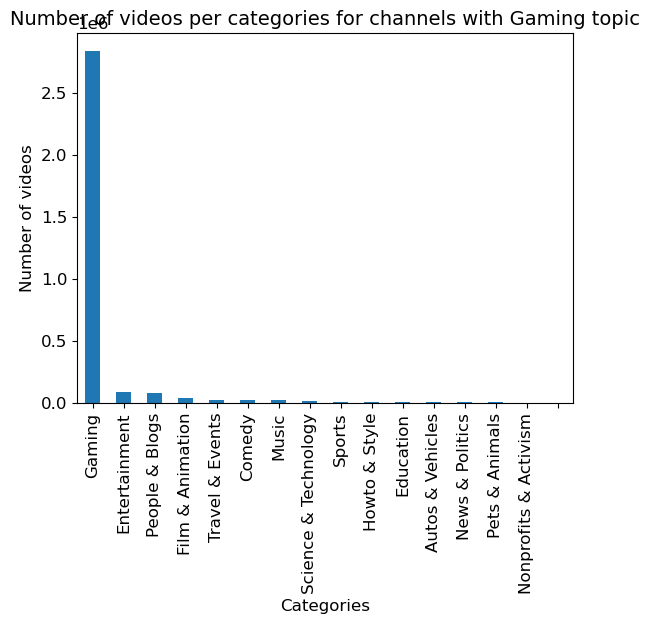

In [347]:
video_metadatas.categories.value_counts().plot(kind="bar")
plt.title("Number of videos per categories for channels with Gaming topic")
plt.xlabel("Categories")
plt.ylabel("Number of videos")


Find channels with unique topic


In [348]:
gaming_channels_with_categories = video_metadatas.groupby("channel_id").apply(
    lambda group: group.categories.unique()
)
unique_topic_gaming = gaming_channels_with_categories.loc[
    gaming_channels_with_categories.str.len() == 1
]
non_unique_topic_gaming = gaming_channels_with_categories.loc[
    gaming_channels_with_categories.str.len() > 1
]
print("nb of channels with unique topic Gaming : ", unique_topic_gaming.shape)
print("nb of channels without unique topic Gaming : ", non_unique_topic_gaming.shape)
unique_topic_gaming.value_counts()


nb of channels with unique topic Gaming :  (5598,)
nb of channels without unique topic Gaming :  (8782,)


[Gaming]              5576
[Entertainment]          8
[People & Blogs]         5
[Film & Animation]       4
[Education]              2
[Music]                  2
[Howto & Style]          1
dtype: int64

In [349]:
unique_topic_gaming_channels_descript = df_channels[
    df_channels.channel.isin(unique_topic_gaming.index.values)
]
non_unique_topic_gaming_channels_descript = df_channels[
    df_channels.channel.isin(non_unique_topic_gaming.index.values)
]


### Now we have the dataset to check the differences between unique and non unique categories channels


In [350]:
def get_confidence_interval(data):
    rng = np.random.default_rng()
    return bootstrap(
        (data,),
        np.mean,
        confidence_level=0.95,
        random_state=rng,
    ).confidence_interval


In [351]:
conf1 = get_confidence_interval(unique_topic_gaming_channels_descript.subscribers_cc)
print(
    "95% confidence interval of number of subs for unique Gaming channels [{:_}, {:_}]".format(
        int(conf1[0]), int(conf1[1])
    )
)
conf2 = get_confidence_interval(
    non_unique_topic_gaming_channels_descript.subscribers_cc
)
print(
    "95% confidence interval of number of subs for non unique Gaming channels [{:_}, {:_}]".format(
        int(conf2[0]), int(conf2[1])
    )
)


95% confidence interval of number of subs for unique Gaming channels [137_250, 161_484]
95% confidence interval of number of subs for non unique Gaming channels [131_238, 163_315]


From these statistics, we can notice that diverse channels have no more subs in general. 


In [364]:
unique_topic_gaming_channels_descript["only_gaming"] = 1
print(unique_topic_gaming_channels_descript.shape)
non_unique_topic_gaming_channels_descript["only_gaming"] = 0
print(non_unique_topic_gaming_channels_descript.shape)


(5598, 9)
(8782, 9)


In [365]:
unique_and_non_unique = unique_topic_gaming_channels_descript.append(
    non_unique_topic_gaming_channels_descript
)
unique_and_non_unique.head(2)


,category_cc,join_date,channel,name_cc,subscribers_cc,videos_cc,subscriber_rank_sb,weights,only_gaming
152,Gaming,2013-01-31,UCD1Em4q90ZUK2R5HKesszJg,Clash of Clans,14600000,343,234.0,2.087,1
233,Gaming,2013-05-24,UCC-RHF_77zQdKcA75hr5oTQ,FGTeeV,12100000,1276,378.0,2.087,1


In [366]:
unique_and_non_unique["subscribers_cc_log"] = np.log(
    unique_and_non_unique.subscribers_cc,
    where=unique_and_non_unique.subscribers_cc != 0,
)
mod = smf.ols(
    formula="subscribers_cc_log ~ only_gaming",
    data=unique_and_non_unique,
)

# Fits the model (find the optimal coefficients, adding a random seed ensures consistency)
np.random.seed(2)
res = mod.fit()

# Print thes summary output provided by the library.
print(res.summary())


                            OLS Regression Results                            
Dep. Variable:     subscribers_cc_log   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     45.88
Date:                Wed, 21 Dec 2022   Prob (F-statistic):           1.30e-11
Time:                        00:34:16   Log-Likelihood:                -23569.
No. Observations:               14380   AIC:                         4.714e+04
Df Residuals:                   14378   BIC:                         4.716e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      10.6935      0.013    804.093      

Channel with only gaming have more subscribers than ones with diverse categories and the coefficient is meaningful
